In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.polynomial.chebyshev import Chebyshev

In [26]:
#Calculate the theoretical magnification of a Point Source Point Lens event
def pspl_model(t, t0, u0, tE):
    # Avoid division by zero if t roughly equals t0
    u = np.sqrt(u0**2 + ((t - t0) / tE)**2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return A

# Scale the time array to the interval [-1, 1], which is the standard for Chebyshev polynomials.
def scale_time(t):
    t_min, t_max = np.min(t), np.max(t)
    # Linear mapping: t -> [-1, 1]
    # Handle case where t_max == t_min (single point or empty) to avoid division by zero
    if t_max == t_min:
        return np.zeros_like(t)
        
    return 2 * (t - t_min) / (t_max - t_min) - 1

#Now fit the functions

#fit chebyshev polynomial to the data (t, y) and return coefficients
def fit_chebyshev(t, y, degree=50):
    # Scale time to [-1, 1] for standard
    t_scaled = scale_time(t)
    
    # 2. Fit the polynomial
    # domain=[-1, 1] is standard
    cheb_fit = Chebyshev.fit(t_scaled, y, deg=degree, domain=[-1, 1])
    
    return cheb_fit.coef, cheb_fit

#Now fit PSPL to lightcurve data and return best fit parameters
def fit_pspl(t, m, e, initial_guess=None):   
    # Objective function (Chi-Squared)
    def chi_squared(params, t_data, m_data, e_data):
        t0, u0, tE = params
        model = pspl_model(t_data, t0, u0, tE)
        # Avoid division by zero in errors
        e_safe = np.where(e_data == 0, 1e-9, e_data)
        return np.sum(((m_data - model) / e_safe)**2)
        
   # Generate guess if none provided
    if initial_guess is None:
        t0_guess = t[np.argmax(m)]
        u0_guess = 0.5 # Rough guess
        tE_guess = (t.max() - t.min()) / 5
        initial_guess = [t0_guess, u0_guess, tE_guess]

    # Minimize
    result = minimize(chi_squared, initial_guess, args=(t, m, e), method='Nelder-Mead')
    
    best_params = result.x
    model_curve = pspl_model(t, *best_params)
    
    return best_params, model_curve


# Fit data with chebyshev (a), fit data with PSPL, fit PSPL with chebyshev (b), and calculate metric sum ((a-b)^2)
def calculate_chebyshev_metric(t, m, e, degree=50):

    # STEP 1: Fit Data with Chebyshev (a) (degree 50)
    coeffs_a, poly_a = fit_chebyshev(t, m, degree=degree)
    
    #STEP 2: Fit Data with PSPL
    pspl_params, pspl_curve = fit_pspl(t, m, e)
    print(f"   Best Fit PSPL: t0={pspl_params[0]:.2f}, u0={pspl_params[1]:.3f}, tE={pspl_params[2]:.2f}")

    #STEP 3: Fit the PSPL curve (from step 2) with Chebyshev (b)
    # fit the pspl_curve values, not the original m
    coeffs_b, poly_b = fit_chebyshev(t, pspl_curve, degree=degree)

    # STEP 4: Calculate Metric ((a-b)^2)
    # Make sure both arrays are same length (sometimes fit returns fewer coeffs if high orders are 0)
    # Pad with zeros if necessary
    max_len = max(len(coeffs_a), len(coeffs_b))
    a_padded = np.pad(coeffs_a, (0, max_len - len(coeffs_a)))
    b_padded = np.pad(coeffs_b, (0, max_len - len(coeffs_b)))

    #((a-b)^2)
    diff_squared = (a_padded - b_padded)**2
    metric = np.sum(diff_squared)
    
    print(f"Calculated Metric Sum((a_i - b_i)^2): {metric:.6e}")
    print(coeffs_a)
    print(coeffs_b)
    
    return metric, poly_a, pspl_curve, poly_b

   Best Fit PSPL: t0=1401.41, u0=3.157, tE=10.19
Calculated Metric Sum((a_i - b_i)^2): 2.846798e-04
[ 1.01082583e+00 -1.62643404e-03 -5.24664024e-03 -1.27115460e-03
 -4.61170197e-03 -1.43292157e-03  4.68588513e-03  5.11331642e-03
  1.28536078e-03 -2.56794831e-03 -4.49248413e-03 -2.63601387e-03
  1.31252391e-03  4.10232034e-03  3.27719977e-03 -1.31071822e-05
 -3.28648321e-03 -3.48076010e-03 -1.09439584e-03  2.43758589e-03
  3.59337836e-03  1.96571399e-03 -1.33950949e-03 -3.10273259e-03
 -2.46103255e-03  3.17742834e-04  2.66301091e-03  2.71581076e-03
  5.22803715e-04 -1.93840743e-03 -2.74999293e-03 -1.28801531e-03
  1.12062896e-03  2.68617512e-03  1.63083215e-03 -8.11352345e-05
 -2.29113506e-03 -1.76979825e-03 -5.42717930e-04  1.60558497e-03
  1.96098362e-03  9.81628397e-04 -9.88023271e-04 -1.83866562e-03
 -1.52383095e-03  4.01364375e-04  1.25437802e-03  1.63217538e-03
 -7.49705343e-05 -9.09207655e-04 -1.81810307e-03]
[ 1.01178118e+00 -1.25490741e-03 -2.17055208e-03  1.85580282e-04
  1.4

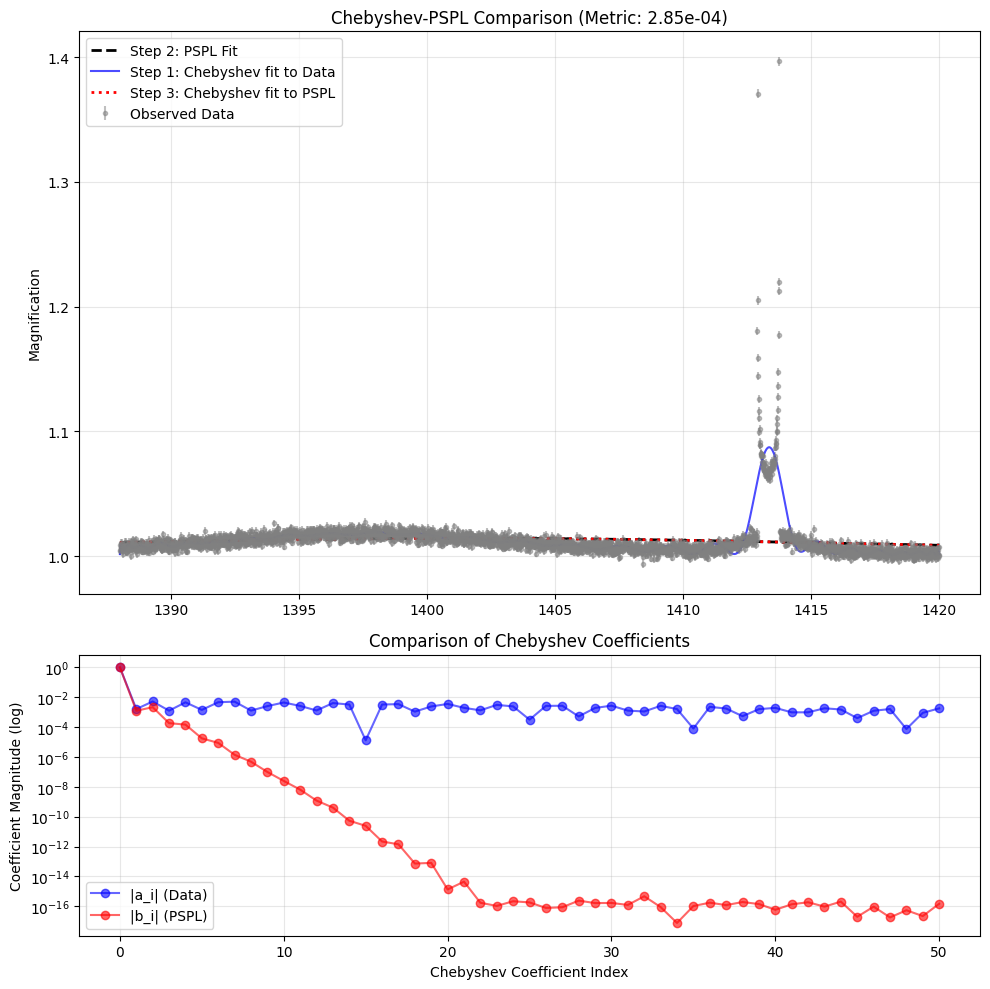

In [27]:
if __name__ == "__main__":
    
    # Define the range (where the lightcurve is)
    X_MIN = 1385
    X_MAX = 1420


    # Load file
    data = pd.read_csv("cassan_30_6_1468.csv")
    t_full = data['t'].values
    y_full = data['m'].values
    err_full = data['e'].values
        
    # Filter data
    mask = (t_full >= X_MIN) & (t_full <= X_MAX)
        
    t_data = t_full[mask]
    y_data = y_full[mask]
    err_data = err_full[mask]
   

    # --- B. Run the Metric Calculation ---
    degree = 50
    metric_val, poly_data, pspl_fit_curve, poly_pspl = calculate_chebyshev_metric(t_data, y_data, err_data, degree)

    # --- C. Plotting ---
    t_scaled = scale_time(t_data)
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
    
    # Top Plot: Lightcurves
    ax = axes[0]
    ax.errorbar(t_data, y_data, yerr=err_data, fmt='.', color='gray', alpha=0.5, label='Observed Data')
    ax.plot(t_data, pspl_fit_curve, 'k--', linewidth=2, label='Step 2: PSPL Fit')
    
    # Plot Chebyshev fits (evaluated on scaled time)
    # We plot over the data points to check fit quality
    ax.plot(t_data, poly_data(t_scaled), 'b-', alpha=0.7, label=f'Step 1: Chebyshev fit to Data')
    ax.plot(t_data, poly_pspl(t_scaled), 'r:', linewidth=2, label=f'Step 3: Chebyshev fit to PSPL')
    
    ax.set_ylabel('Magnification')
    ax.set_title(f'Chebyshev-PSPL Comparison (Metric: {metric_val:.2e})')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Bottom Plot: Coefficients Comparison
    ax2 = axes[1]
    # Get coefficients
    coeffs_a = poly_data.coef
    coeffs_b = poly_pspl.coef
    
    indices = np.arange(len(coeffs_a))
    
    ax2.plot(indices, np.abs(coeffs_a), 'bo-', label='|a_i| (Data)', alpha=0.6)
    ax2.plot(indices, np.abs(coeffs_b), 'ro-', label='|b_i| (PSPL)', alpha=0.6)
    ax2.set_yscale('log')
    ax2.set_xlabel('Chebyshev Coefficient Index')
    ax2.set_ylabel('Coefficient Magnitude (log)')
    ax2.set_title('Comparison of Chebyshev Coefficients')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [22]:
print(a_padded)
print(b_padded)

NameError: name 'a_padded' is not defined